# Permanent portfolio

For a description of this strategy see [here](http://seekingalpha.com/article/1088961-harry-browne-s-permanent-portfolio-and-market-stages) .
It holds a long position of stocks,gold,bonds and cash. Cash is replaced by TIP as described in the linked article.

In [1]:
%pylab inline
%run common.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.pylab import *

import tradingWithPython as twp # we'll use performance metric function from this module
import tradingWithPython.lib.yahooFinance as yf # used to get data from yahoo finance
import pandas as pd # as always.



twp version: 3.1.2.0
pandas version: 0.21.0


## Get price data##
We can use `HistData` class to get multiple prices from yahoo all at once, adjustment for splits and dividends is done automatically.

In [5]:
import imp
imp.reload(yf)

symbols = ['SPY','TLT','GLD','TIP'] # define symbols (tickers)

hData = yf.getHistoricData(symbols, sDate=(2001,1,1)) # create HistData class



 [*********************100%***********************]  4 of 4 complete

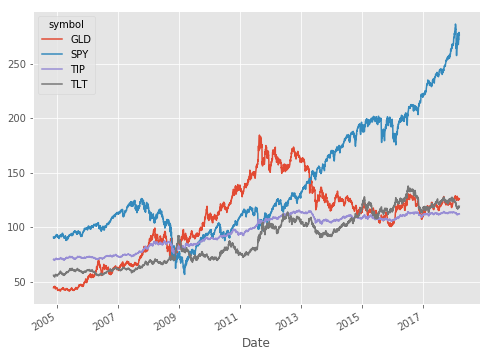

In [11]:
C = hData.xs('adj_close',level=1,axis=1).dropna() #  closing prices of the symbols. 'dropna()' removes all incomplete data rows,
                                         #  so the shortest price series determines dataset length
C.plot(grid=True)

## Simulate portfolio##
Suppose we would go long on each day, allocating equal `$` amount to each position. For simplicity let's assume daily frictionless rebalancing. This means that portfolio return on each day would be a sum of individual returns. 

In [12]:
R = C.pct_change() # daily change compared to close of the previous day
weight = pd.Series({'SPY':25., 'TLT':25., 'GLD':25., 'TIP':25.}) # capital weights all at 25$

print('Portfolio weights in $:\n', weight)


Portfolio weights in $:
 GLD    25.0
SPY    25.0
TIP    25.0
TLT    25.0
dtype: float64


because a daily total position is 4x25=100$ , total pnl in dollars is equal to total pnl in %. By using `cumsum()` function a daily rebalanced portfolio is simulated. A `cumprod()` function would simulate reinvested returns.

In [13]:
pnl = pd.DataFrame(index=C.index) # init pnl dataframe with the same dates as the Close prices
pnl['strategy'] = (R*weight).sum(axis=1) # portfolio returns, sum over rows to achieve daily pnl

pnl['SPY'] = 100*C['SPY'].pct_change() # pnl for buy-and-hold of SPY


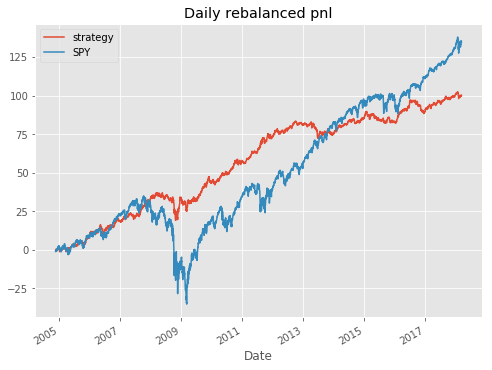

In [14]:
pnl.cumsum().plot(grid=True)
title('Daily rebalanced pnl')

Even from the first glance the strategy looks pretty good! No let's calculate some statistics:

In [15]:
print('----Sharpe:----')
print(twp.sharpe(pnl))

----Sharpe:----
strategy    0.98
SPY         0.54
dtype: float64


Max drawdown: 5.89 %


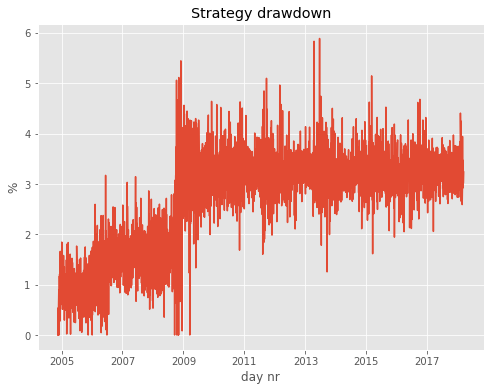

In [16]:
d,t = twp.drawdown(pnl['strategy']) # calculate drawdown and drawdown duration
plot(d)
grid(True)
title('Strategy drawdown')
ylabel('%')
xlabel('day nr')

print('Max drawdown: %.2f %%' % d.max())

The drawdown is worst around the end of 2008. Probably the strategy should not trade in periods of high volatility. let's see if we can do something about that.

In [17]:
# get data from CBOE

vix = twp.cboe.getHistoricData('VIX')['VIX']
vix = vix.reindex(C.index)

Now we can calculate a strategy with some logic. To do this a `tradeDir` series is created, which contains the trading direction of the strategy. There are three options: short (-1), long (1) and not-trading = (0).
`tradeDir` is initialized with all elements set to 1 (long), after that some days are adjusted according to values of  *vix*

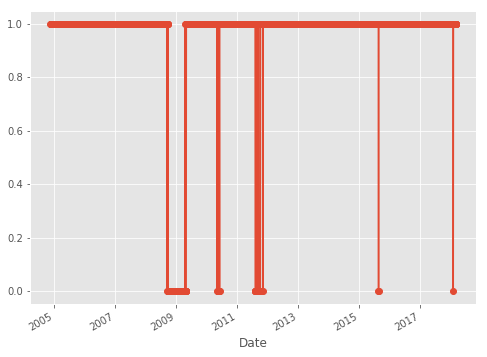

In [18]:
tradeDir =pd.Series(index=C.index,data=1) # trading direction. 1 = long 0 = none, -1 = short. Init with all long positions

tradeDir[vix>35] = 0 # do not trade when VIX is higher than this value
tradeDir = tradeDir.shift(1) # this shift is VERY important because the returns are effective the NEXT day. 

tradeDir.plot(style = 'o-')

---------Sharpe-------
 strategy     0.98
SPY          0.54
strategy+    1.16
dtype: float64


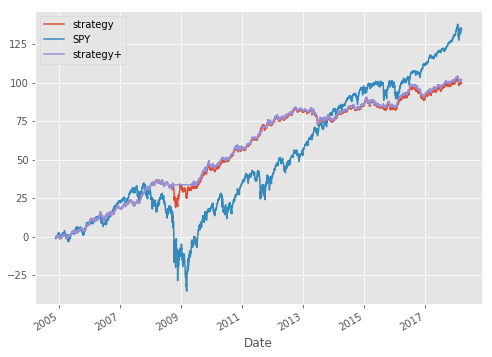

In [19]:
pnl['strategy+'] = tradeDir*((R*weight).sum(axis=1)) # sum along rows, then multiply by tradeDir

pnl.cumsum().plot(grid=True)
print('---------Sharpe-------\n', twp.sharpe(pnl))

Max drawdown: 4.56 %


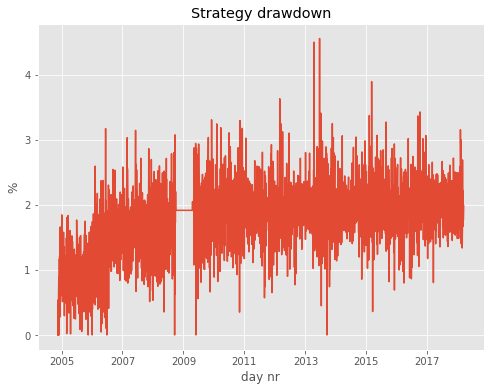

In [20]:
d,t = twp.drawdown(pnl['strategy+']) # calculate drawdown and drawdown duration
plot(d)
grid(True)
title('Strategy drawdown')
ylabel('%')
xlabel('day nr')


print('Max drawdown: %.2f %%' % d.max())

## Conclusion##
The strategy on its own performs pretty well compared to buy-and-hold on stocks. A simple inclusion of the VIX index can drastically decrease the drawdown by more than factor 2. 
